# Bonner sphere mapping with the NEW target

- Code and data is in /Users/hkromer/02_PhD/02_Data/06.BS_Mapping/2017-12-21_BS_Mapping
- Some report can already be found in /Users/hkromer/02_PhD/04_Publiations/04_Reports/05_BSMapping/2018-01-04_BS_Mapping.docx

In [1]:
outputfolder = '/Users/hkromer/polybox/Thesis/Chapters/DetailedNeutronGeneratorCharacterization/Figures/'

In [2]:
import time
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import datetime
from matplotlib.ticker import AutoMinorLocator
import re
import copy

def extractDirection(df):
    if 'N' in df:
        return 'North'
    if 'S' in df:
        return 'South'
    if 'E' in df:
        return 'East'

def extractDistance(df):
    t = re.findall(r'(\d+)', df)
    return t[0]

import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

## Read the data

- script to get all data from the database is already executed
- also some processing on the statistics has been done


- BS_norm_dose is the counts in the BS normed by the mean of the dose (measured with BS1), again in the respective measurement interval. Normalized by position 70 North 

In [3]:
data_fname = '/Users/hkromer/02_PhD/02_Data/06.BS_Mapping/BS_mapping/2017-12-21_BS_Mapping/df_averaged_results.csv'
df = pd.read_csv(data_fname, index_col=0)


df['BS_norm_dose'] = df['BS']/df['dose']
norm_BS = df['BS_norm_dose'][(df['direction'] == 'North')&(df['distance']==70)].values[0]
df['BS_norm_dose'] = df['BS_norm_dose']/norm_BS
df

,BS,HV,WS,dose,refDet,run,output,output_from_BS,direction,distance,output_norm_WS,output_from_BS_norm_WS,output_norm_refDet,output_from_BS_norm_refDet,BS_norm_dose
0,18459.222222,90,1227.777778,958.627441,1944.076613,75cmE,2.893334e+07,2.533143e+07,East,75,23565.614037,20631.935040,14882.817396,13030.058171,0.656846
1,10973.833333,90,1184.000000,963.577945,1892.451613,100cmE,2.908275e+07,2.736429e+07,East,100,24563.136479,23111.729566,15367.766020,14459.702758,0.388483
2,5511.000000,90,1189.666667,968.846688,1895.551613,150cmE,2.924178e+07,2.732254e+07,East,150,24579.805296,22966.550138,15426.525363,14414.030703,0.194033
3,4599.666667,90,1177.750000,927.818523,1866.678886,175cmE,2.800346e+07,2.921244e+07,East,175,23777.084343,24803.599011,15001.755953,15649.418312,0.169108
4,24750.923077,90,1203.615385,911.503259,1907.118280,75cmS,2.751103e+07,3.146750e+07,South,75,22856.996838,26144.150297,14425.446673,16500.026166,0.926261
5,14178.210526,90,1193.947368,973.192311,1918.896057,100cmS,2.937293e+07,2.978038e+07,South,100,24601.532366,24942.791552,15307.204741,15519.538029,0.496962
6,6879.181818,90,1197.454545,956.295014,1898.497067,150cmS,2.886294e+07,3.068331e+07,South,150,24103.578657,25623.778463,15203.046831,16161.894858,0.245383
7,4728.727273,90,1206.454545,986.882828,1910.860704,195cmS,2.978614e+07,3.265248e+07,South,195,24688.988693,27064.823510,15587.814733,17087.838627,0.163448
8,27752.500000,90,1174.083333,946.678233,1917.368280,70cmN,2.857269e+07,2.572285e+07,North,70,24336.164976,21908.879112,14902.033167,13415.706357,1.000000
9,14371.250000,90,1168.916667,976.995819,1895.951613,100cmN,2.948773e+07,2.573080e+07,North,100,25226.548058,22012.519661,15552.998435,13571.443982,0.501767


In [4]:
df_north = df[ df['direction'] == 'North']
df_south = df[ df['direction'] == 'South']
df_east = df[ df['direction'] == 'East']

# for df in [df_north, df_south, df_east]:
#     df = df.sort_values(['distance'], ascending=True)

In [5]:
df

,BS,HV,WS,dose,refDet,run,output,output_from_BS,direction,distance,output_norm_WS,output_from_BS_norm_WS,output_norm_refDet,output_from_BS_norm_refDet,BS_norm_dose
0,18459.222222,90,1227.777778,958.627441,1944.076613,75cmE,2.893334e+07,2.533143e+07,East,75,23565.614037,20631.935040,14882.817396,13030.058171,0.656846
1,10973.833333,90,1184.000000,963.577945,1892.451613,100cmE,2.908275e+07,2.736429e+07,East,100,24563.136479,23111.729566,15367.766020,14459.702758,0.388483
2,5511.000000,90,1189.666667,968.846688,1895.551613,150cmE,2.924178e+07,2.732254e+07,East,150,24579.805296,22966.550138,15426.525363,14414.030703,0.194033
3,4599.666667,90,1177.750000,927.818523,1866.678886,175cmE,2.800346e+07,2.921244e+07,East,175,23777.084343,24803.599011,15001.755953,15649.418312,0.169108
4,24750.923077,90,1203.615385,911.503259,1907.118280,75cmS,2.751103e+07,3.146750e+07,South,75,22856.996838,26144.150297,14425.446673,16500.026166,0.926261
5,14178.210526,90,1193.947368,973.192311,1918.896057,100cmS,2.937293e+07,2.978038e+07,South,100,24601.532366,24942.791552,15307.204741,15519.538029,0.496962
6,6879.181818,90,1197.454545,956.295014,1898.497067,150cmS,2.886294e+07,3.068331e+07,South,150,24103.578657,25623.778463,15203.046831,16161.894858,0.245383
7,4728.727273,90,1206.454545,986.882828,1910.860704,195cmS,2.978614e+07,3.265248e+07,South,195,24688.988693,27064.823510,15587.814733,17087.838627,0.163448
8,27752.500000,90,1174.083333,946.678233,1917.368280,70cmN,2.857269e+07,2.572285e+07,North,70,24336.164976,21908.879112,14902.033167,13415.706357,1.000000
9,14371.250000,90,1168.916667,976.995819,1895.951613,100cmN,2.948773e+07,2.573080e+07,North,100,25226.548058,22012.519661,15552.998435,13571.443982,0.501767


In [6]:
df_south['BS_norm_dose']

4    0.926261
5    0.496962
6    0.245383
7    0.163448
Name: BS_norm_dose, dtype: float64

## Load the total counts in the LB6411 per source particle

- is stored in the MCNP data files: /Volumes/hkromer/10_Experiments/02_MCNP/
- a list of each mcnp run is in the notion card MCNP Run Overview

- in each MCNP run folder, the file "df_counts.csv" contains the total counts in the LB6411 per MCNP source particle. In this dataframe, the response of the LB6411 is already accounted for


In [7]:
"""
M_tot from MCNP: total counts in LB6411 per source particle

1. relative behaviour. Set M_tot(55 cm N) as the reference point and check the behaviour of the countrate for the other
directions.
"""

MCNP_data_fname = '/Users/hkromer/02_PhD/02_Data/06.BS_Mapping/BS_mapping/2017-12-21_BS_Mapping/MCNP_225_df_counts.csv'

df_mcnp = pd.read_csv(MCNP_data_fname, index_col=0)
M_tot = df_mcnp.iloc[-1]
M_tot = pd.DataFrame(M_tot)
# print(M_tot)
M_tot['direction'] = M_tot.index
M_tot['distance'] = M_tot.index

M_tot['direction'] = M_tot['direction'].map(extractDirection)
M_tot['distance'] = pd.to_numeric(M_tot['distance'].map(extractDistance))

lstDirection = ['North', 'South', 'East']


df_M_tot = pd.DataFrame()
d = np.arange(20, 240, 1)  # distance source to detector in cm

df_M_tot['distance'] = d

# interpolate M_tot values
M_tot = M_tot.reset_index()
# print(M_tot)
for dir in lstDirection:
    t = M_tot[['distance','Total']][M_tot['direction'] == dir]
    t.columns = ['distance', dir]
    df_M_tot = pd.merge(df_M_tot, t, how='left', on=['distance'])
    # df_res = pd.merge(df_res, df_ref, how='left', on=['date'])
    df_M_tot[dir] = df_M_tot[dir].interpolate(method='linear')
# print(df_M_tot.head(55))

# normalize with 70 cm N
M_55N = df_M_tot['North'][ df_M_tot['distance'] == 70 ]

for dir in lstDirection:
    df_M_tot[dir] = df_M_tot[dir].apply(lambda x: x / M_55N)

In df_M_tot the entries in the column North, South and East refer to the counts at this particular position (indicated by the column value in distance) in the LB6411 normed to the counts at the position 55 north.

The position 55 cm north is taken as an (arbitrary) reference.

In [8]:
df_M_tot.head()

,distance,North,South,East
0,20,9.848855,NaN,8.225343
1,21,9.545085,NaN,7.962587
2,22,9.241315,NaN,7.699831
3,23,8.937544,NaN,7.437075
4,24,8.633774,NaN,7.174319


## Relationship between North, South, West, East, and X, Y in the thesis.

- North is +x direction (forward)
- South is -x direction (backwards)
- East is +y direction (side)

## Plot to show the relationship between measured counts in the BS2 and what would be expected from MCNP model.

Data is relative to 55 cm in north position, because MCNP gives results per source particle.

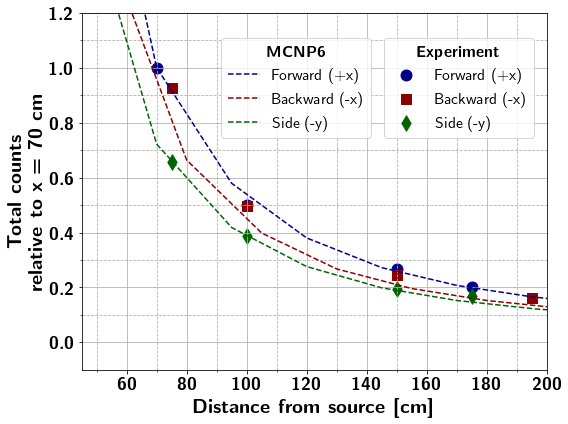

In [9]:
fs = 20
markersize = 120
figname = 'BS_mapping_new_target_counts_in_BS_vs_MCNP'
if not os.path.exists(outputfolder+'/'+figname):
    os.makedirs(outputfolder+'/'+figname)
# plots
normtypes = ['BS_norm_dose']
for normtype in normtypes:
    fig = plt.figure(figsize=(8, 6))
    ax1 = fig.add_subplot(1, 1, 1)
    
    # Plot of the expected MCNP counts
    ax1.plot(df_M_tot['distance'], df_M_tot['North'], '--', label=r"Forward (+x)", color='darkblue')
    ax1.plot(df_M_tot['distance'], df_M_tot['South'], '--', label=r"Backward (-x)", color='darkred')
    ax1.plot(df_M_tot['distance'], df_M_tot['East'], '--', label=r"Side (-y)", color='darkgreen')
    

    
#     _1 = ax1.scatter(df_north['distance'], df_north[normtype], label=r"Forward (+x)",  marker="o", color='darkblue', s=markersize)
    _1 = ax1.scatter(df_north['distance'], df_north[normtype],  marker="o", color='darkblue', s=markersize)
#     _2 = ax1.scatter(df_south['distance'], df_south[normtype], label=r"Backward (-x)",  marker="s", color='darkred', s=markersize)
    _2 = ax1.scatter(df_south['distance'], df_south[normtype],  marker="s", color='darkred', s=markersize)
#     _3 = ax1.scatter(df_east['distance'], df_east[normtype], label=r"Side (+y)",  marker="d", color='darkgreen', s=markersize)
    _3 = ax1.scatter(df_east['distance'], df_east[normtype], marker="d", color='darkgreen', s=markersize)

    my_handles, my_labels = ax1.get_legend_handles_labels()
    leg1 = plt.legend([my_handles[0], my_handles[1], my_handles[2]], [my_labels[0], my_labels[1], my_labels[2]], loc=(0.3, 0.65), markerscale=0, fontsize=fs-4)
    leg1.set_title(r"\textbf{MCNP6}", prop = {'size': fs-4})

    leg2 = ax1.legend([_1,_2,_3],[r'Forward (+x)',r'Backward (-x)',r'Side (-y)'], loc=(0.65, 0.65), fontsize=fs-4)
    leg2.set_title(r"\textbf{Experiment}", prop = {'size': fs-4})
    # Manually add the first legend back
    ax1.add_artist(leg1)
#     ax1.errorbar(df_east['distance'], df_east[normtype], xerr=df_east['distance_err'], label=r"East\_exp",  ls='none', marker='s', color='olive', capsize=5)
    plt.xlabel(r"\textbf{Distance from source [cm]}", fontsize=fs)
    plt.ylabel(r"\textbf{Total counts}"+ "\n" + r"\textbf{relative to x = 70 cm}", fontsize=fs)
#     fig.suptitle(r"\textbf{Total counts expected and measured}")
#     ax1.set_title(r"\textit{Relative to 55 cm North}")
    ax1.grid(b=True, which='major', linestyle='-')
    ax1.grid(b=True, which='minor', linestyle='--')
#     fig.subplots_adjust(bottom=0.5)
#     plt.gcf().autofmt_xdate()
    plt.xlim(45,200)
    plt.ylim(-0.1,1.2)
    # tick font size
    ax1.tick_params('x', colors='black', labelsize=fs-2)	
    ax1.tick_params('y', colors='black', labelsize=fs-2)	
    # minor ticks x
    minor_locator = AutoMinorLocator(2)
    ax1.xaxis.set_minor_locator(minor_locator)
    # minor ticks y
    minor_locator = AutoMinorLocator(2)
    ax1.yaxis.set_minor_locator(minor_locator)
    
#     plt.legend(loc='best', title=r"\textbf{Legend}")
    plt.tight_layout()
    plt.savefig(f'{outputfolder}/{figname}/{figname}.pdf')
    plt.show()
    plt.close()


# Table with the relative differences

- values are in percent

In [10]:
dict_dir = {'N': 'North', 'S': 'South', 'E': 'East', 'W': 'West'}
def getTheocounts(row):
    d = row['distance']
    mcnp_counts = df_M_tot[ df_M_tot['distance'] == d ]
    return mcnp_counts[row['direction']].values[0]

ex = df[['distance', 'direction', 'BS_norm_dose']]

ex['mcnp_counts'] = ex.apply(lambda x: getTheocounts(x), axis=1)
ex['relDiff'] = 100*np.abs(ex['mcnp_counts']-ex['BS_norm_dose'])/ex['BS_norm_dose']
ex

<ipython-input-10-4d9d09e5415b>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['mcnp_counts'] = ex.apply(lambda x: getTheocounts(x), axis=1)
<ipython-input-10-4d9d09e5415b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ex['relDiff'] = 100*np.abs(ex['mcnp_counts']-ex['BS_norm_dose'])/ex['BS_norm_dose']


,distance,direction,BS_norm_dose,mcnp_counts,relDiff
0,75,East,0.656846,0.660942,0.623488
1,100,East,0.388483,0.389787,0.335672
2,150,East,0.194033,0.189530,2.320978
3,175,East,0.169108,0.146752,13.220068
4,75,South,0.926261,0.810339,12.515041
5,100,South,0.496962,0.451200,9.208242
6,150,South,0.245383,0.210356,14.274384
7,195,South,0.163448,0.135513,17.090731
8,70,North,1.000000,1.000000,0.000000
9,100,North,0.501767,0.539234,7.467059


## Comparison between output measured from BS1 (connected to the interlock) and BS2 (connected to the readout and moved around the room)

- original code is in /Users/hkromer/02_PhD/02_Data/06.BS_Mapping/BS_mapping/2017-10-12_BS_Mapping/2017-10-12_compare_neutron_output_orig_and_switchedSpheres.py

In [11]:
fname = '/Users/hkromer/02_PhD/02_Data/06.BS_Mapping/BS_mapping/2017-12-21_BS_Mapping/df_averaged_results.csv'
df = pd.read_csv(fname, index_col=0)
df.head()

,BS,HV,WS,dose,refDet,run,output,output_from_BS,direction,distance,output_norm_WS,output_from_BS_norm_WS,output_norm_refDet,output_from_BS_norm_refDet
0,18459.222222,90,1227.777778,958.627441,1944.076613,75cmE,2.893334e+07,2.533143e+07,East,75,23565.614037,20631.935040,14882.817396,13030.058171
1,10973.833333,90,1184.000000,963.577945,1892.451613,100cmE,2.908275e+07,2.736429e+07,East,100,24563.136479,23111.729566,15367.766020,14459.702758
2,5511.000000,90,1189.666667,968.846688,1895.551613,150cmE,2.924178e+07,2.732254e+07,East,150,24579.805296,22966.550138,15426.525363,14414.030703
3,4599.666667,90,1177.750000,927.818523,1866.678886,175cmE,2.800346e+07,2.921244e+07,East,175,23777.084343,24803.599011,15001.755953,15649.418312
4,24750.923077,90,1203.615385,911.503259,1907.118280,75cmS,2.751103e+07,3.146750e+07,South,75,22856.996838,26144.150297,14425.446673,16500.026166


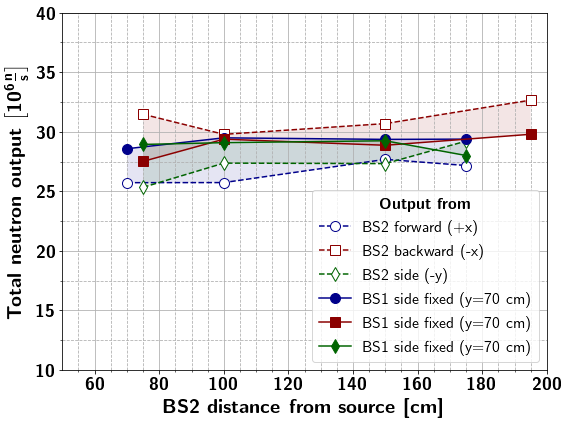

In [12]:
fs = 20
y_scale = 1e6
markersize = 10
xlims = [50, 200]
ylims = [10, 40]
figname = 'BS_mapping_new_target_output_BS2_vs_BS1_ALL'
if not os.path.exists(outputfolder+'/'+figname):
    os.makedirs(outputfolder+'/'+figname)
# plot neutron output
df_north = df[ df['direction'] == 'North']
df_south = df[ df['direction'] == 'South']
df_east = df[ df['direction'] == 'East']
df_south = df_south.sort_values(['distance'], ascending=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
# x
minor_locator = AutoMinorLocator(4)
ax1.xaxis.set_minor_locator(minor_locator)
# y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.plot(df_north['distance'], df_north['output_from_BS']/y_scale, '--', label=r"BS2 forward (+x)", marker="o", markersize=markersize, color='darkblue', markerfacecolor='white')
ax1.plot(df_south['distance'], df_south['output_from_BS']/y_scale, '--', label=r"BS2 backward (-x)", marker="s", markersize=markersize, color='darkred', markerfacecolor='white')
ax1.plot(df_east['distance'], df_east['output_from_BS']/y_scale, '--', label=r"BS2 side (-y)", marker='d', markersize=markersize, color='darkgreen', markerfacecolor='white')

ax1.plot(df_north['distance'], df_north['output']/y_scale,  label=r"BS1 side fixed (y=70 cm)", marker="o", markersize=markersize, color='darkblue')
ax1.plot(df_south['distance'], df_south['output']/y_scale, label=r"BS1 side fixed (y=70 cm)", marker="s", markersize=markersize, color='darkred')
ax1.plot(df_east['distance'], df_east['output']/y_scale, label=r"BS1 side fixed (y=70 cm)", marker='d', markersize=markersize, color='darkgreen')
# fig.subplots_adjust(left=0.14)
plt.xlabel(r'\textbf{BS2 distance from source [cm]}', fontsize=fs)
plt.ylabel(r'\textbf{Total neutron output} $\left[10^6 \frac{n}{s} \right]$', fontsize=fs)



ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1e7))
# ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
plt.ylim(ylims)
plt.xlim(xlims)
# ticks
# y_ticks = np.arange(1.0e6, 10e6+1.0e6, 1.0e6)
# y = np.arange(1, 10+1, 1)
# plt.yticks(y_ticks, y)
ax1.tick_params('x', colors='black', labelsize=fs-2)	
ax1.tick_params('y', colors='black', labelsize=fs-2)	
# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)

plt.gca().fill_between(df_north['distance'],
                       df_north['output_from_BS']/y_scale, df_north['output']/y_scale,
                       facecolor='darkblue',
                       alpha=0.1)
plt.gca().fill_between(df_south['distance'],
                       df_south['output_from_BS']/y_scale, df_south['output']/y_scale,
                       facecolor='darkred',
                       alpha=0.1)
plt.gca().fill_between(df_east['distance'],
                       df_east['output_from_BS']/y_scale, df_east['output']/y_scale,
                       facecolor='darkgreen',
                       alpha=0.1)
leg2 = plt.legend(fontsize=fs-4, loc='lower right')
leg2.set_title(r"\textbf{Output from}", prop = {'size': fs-4})
plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}/{figname}.pdf')
plt.show()
plt.close()

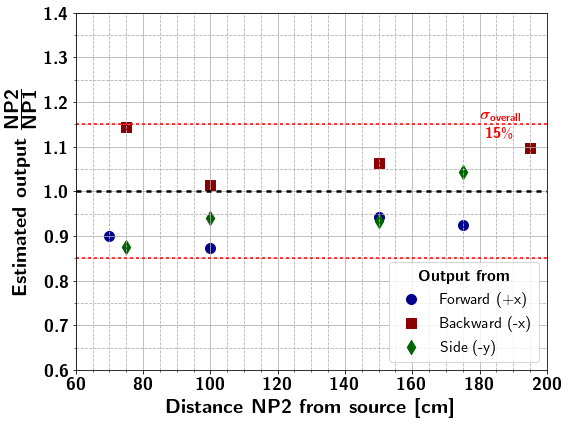

In [13]:
fs = 20
y_scale = 1
markersize = 100
xlims = [60, 200]

figname = 'BS_mapping_new_target_output_NP2_over_NP1'
if not os.path.exists(outputfolder+'/'+figname):
    os.makedirs(outputfolder+'/'+figname)
# plot neutron output
df_north = df[ df['direction'] == 'North']
df_south = df[ df['direction'] == 'South']
df_east = df[ df['direction'] == 'East']
df_south = df_south.sort_values(['distance'], ascending=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
# x
minor_locator = AutoMinorLocator(4)
ax1.xaxis.set_minor_locator(minor_locator)
# y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

# NP2 [north, south, east]
NP2 = [df_north['output_from_BS']/y_scale, df_south['output_from_BS']/y_scale, df_east['output_from_BS']/y_scale]
# ax1.plot(df_north['distance'], NP2[0], '--', label=r"BS2 forward (+x)", marker="o", markersize=markersize, color='darkblue', markerfacecolor='white')
# ax1.plot(df_south['distance'], NP2[1], '--', label=r"BS2 backward (-x)", marker="s", markersize=markersize, color='darkred', markerfacecolor='white')
# ax1.plot(df_east['distance'], NP2[2], '--', label=r"BS2 side (-y)", marker='d', markersize=markersize, color='darkgreen', markerfacecolor='white')

# NP1
NP1 = [df_north['output']/y_scale, df_south['output']/y_scale, df_east['output']/y_scale]
# ax1.plot(df_north['distance'], NP1[0],  label=r"BS1 side fixed (y=70 cm)", marker="o", markersize=markersize, color='darkblue')
# ax1.plot(df_south['distance'], NP1[1], label=r"BS1 side fixed (y=70 cm)", marker="s", markersize=markersize, color='darkred')
# ax1.plot(df_east['distance'], NP1[2], label=r"BS1 side fixed (y=70 cm)", marker='d', markersize=markersize, color='darkgreen')

# distances
distances = [df_north['distance'], df_south['distance'], df_east['distance']]
# ratios NP2/NP1
ratios = []
for ii in range(len(NP2)):
    ratios.append(NP2[ii]/NP1[ii])

data_defense = pd.DataFrame() # for defense
ds = ['north', 'south', 'east']
for d, val in zip(ds, NP1):
    data_defense[f'NP1_{d}'] = val.values.astype(float)
for d, val in zip(ds, NP2):
    data_defense[f'NP2_{d}'] = val.values.astype(float)
for d, val in zip(ds, distances):
    data_defense[f'dist_{d}'] = val.values.astype(float)

ii = 0
labels = ['Forward (+x)', 'Backward (-x)', 'Side (-y)']
markers = ['o', 's', 'd']
colors = ['darkblue', 'darkred', 'darkgreen']
for dist, ratio, label, marker, color in zip(distances, ratios, labels, markers, colors):
    ax1.scatter(dist, ratio, label=label, marker=marker, s=markersize, color=color)
    
    ii = ii + 1
ax1.plot(xlims, [1.0, 1.0], dashes=[2,2], color='black', linewidth=2.5)
ax1.plot(xlims, [1.15, 1.15], dashes=[2,2], color='red', linewidth=1.5)
ax1.plot(xlims, [0.85, 0.85], dashes=[2,2], color='red', linewidth=1.5)
ax1.text(180, 1.16 ,r"$\sigma_{overall}$", fontsize=15, color='red')
ax1.text(182, 1.12 ,r"$15$\%", fontsize=15, color='red')


plt.xlabel(r'\textbf{Distance NP2 from source [cm]}', fontsize=fs)
plt.ylabel(r'\textbf{Estimated output} ' + r'$\frac{\textbf{NP2}}{\textbf{NP1}}$', fontsize=fs)



ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')

plt.ylim(0.6,1.4)
plt.xlim(xlims)

ax1.tick_params('x', colors='black', labelsize=fs-2)	
ax1.tick_params('y', colors='black', labelsize=fs-2)	

leg2 = plt.legend(fontsize=fs-4, loc='lower right')
leg2.set_title(r"\textbf{Output from}", prop = {'size': fs-4})
plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}/{figname}.pdf')
plt.show()
plt.close()

In [28]:
# data_defense = pd.DataFrame() # for defense
# ds = ['north', 'south', 'east']
# for d, val in zip(ds, NP1):
#     data_defense[f'NP1_{d}'] = val.values.astype(float)
# for d, val in zip(ds, NP2):
#     data_defense[f'NP2_{d}'] = val.values.astype(float)
# for d, val in zip(ds, distances):
#     data_defense[f'dist_{d}'] = val.values.astype(float)
    
data_defense.to_csv('/Users/hkromer/02_PhD/04_Publiations/08.Defense/Figures/bonner_sphere_mapping.data')

### North plot

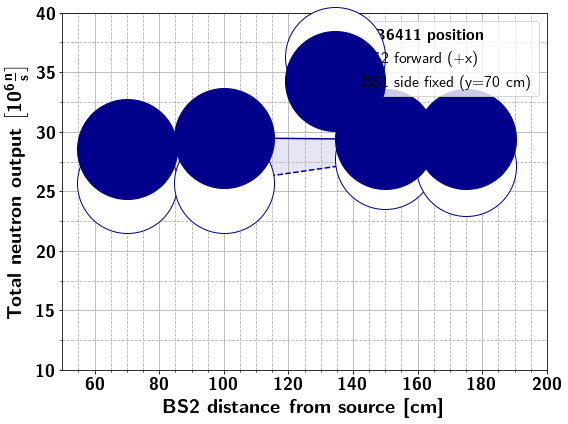

In [14]:
fs = 20
y_scale = 1e6
xlims = [50, 200]
figname = 'BS_mapping_new_target_output_BS2_vs_BS1_NORTH'
if not os.path.exists(outputfolder+'/'+figname):
    os.makedirs(outputfolder+'/'+figname)
# plot neutron output
df_north = df[ df['direction'] == 'North']
df_south = df[ df['direction'] == 'South']
df_east = df[ df['direction'] == 'East']
df_south = df_south.sort_values(['distance'], ascending=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
# x
minor_locator = AutoMinorLocator(4)
ax1.xaxis.set_minor_locator(minor_locator)
# y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
ax1.plot(df_north['distance'], df_north['output_from_BS']/y_scale, '--', label=r"BS2 forward (+x)", marker="o", markersize=markersize, color='darkblue', markerfacecolor='white')
# ax1.plot(df_south['distance'], df_south['total_neutron_output_from_BS2_cps']/y_scale, '--', label=r"BS2 South", marker="d", color='darkred', markerfacecolor='white')
# ax1.plot(df_east['distance'], df_east['total_neutron_output_from_BS2_cps']/y_scale, '--', label=r"BS2 East", marker='s', color='darkgreen', markerfacecolor='white')

ax1.plot(df_north['distance'], df_north['output']/y_scale,  label=r"BS1 side fixed (y=70 cm)", marker="o", markersize=markersize, color='darkblue')
# ax1.plot(df_south['distance'], df_south['total_neutron_output']/y_scale, label=r"BS1 70 cm West", marker="d", color='darkred')
# ax1.plot(df_east['distance'], df_east['total_neutron_output']/y_scale, label=r"BS1 70 cm West", marker='s', color='darkgreen')
# fig.subplots_adjust(left=0.14)
plt.xlabel(r'\textbf{BS2 distance from source [cm]}', fontsize=fs)
plt.ylabel(r'\textbf{Total neutron output} $\left[10^6 \frac{n}{s} \right]$', fontsize=fs)



ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1e7))
# ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
plt.ylim(ylims)
plt.xlim(xlims)
# ticks
# y_ticks = np.arange(1.0e6, 10e6+1.0e6, 1.0e6)
# y = np.arange(1, 10+1, 1)
# plt.yticks(y_ticks, y)
ax1.tick_params('x', colors='black', labelsize=fs-2)	
ax1.tick_params('y', colors='black', labelsize=fs-2)	
# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
plt.gca().fill_between(df_north['distance'],
                       df_north['output_from_BS']/y_scale, df_north['output']/y_scale,
                       facecolor='darkblue',
                       alpha=0.1)
# plt.gca().fill_between(df_south['distance'],
#                        df_south['output_from_BS']/y_scale, df_south['output']/y_scale,
#                        facecolor='darkred',
#                        alpha=0.1)
# plt.gca().fill_between(df_east['distance'],
#                        df_east['output_from_BS']/y_scale, df_east['output']/y_scale,
#                        facecolor='darkgreen',
#                        alpha=0.1)
leg2 = plt.legend(fontsize=fs-4)
leg2.set_title(r"\textbf{LB6411 position}", prop = {'size': fs-4})
plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}/{figname}.pdf')
plt.show()
plt.close()

### South

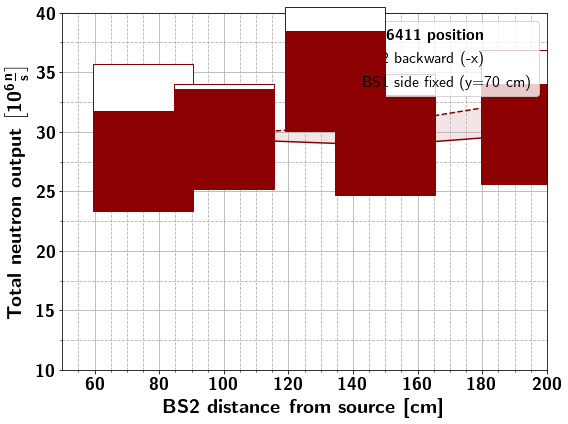

In [15]:
fs = 20
y_scale = 1e6
xlims = [50, 200]
figname = 'BS_mapping_new_target_output_BS2_vs_BS1_SOUTH'
if not os.path.exists(outputfolder+'/'+figname):
    os.makedirs(outputfolder+'/'+figname)
# plot neutron output
df_north = df[ df['direction'] == 'North']
df_south = df[ df['direction'] == 'South']
df_east = df[ df['direction'] == 'East']
df_south = df_south.sort_values(['distance'], ascending=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
# x
minor_locator = AutoMinorLocator(4)
ax1.xaxis.set_minor_locator(minor_locator)
# y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
# ax1.plot(df_north['distance'], df_north['output_from_BS']/y_scale, '--', label=r"BS2 forward (+x)", marker="o", markersize=markersize, color='darkblue', markerfacecolor='white')
ax1.plot(df_south['distance'], df_south['output_from_BS']/y_scale, '--', label=r"BS2 backward (-x)", marker="s", markersize=markersize, color='darkred', markerfacecolor='white')
# ax1.plot(df_east['distance'], df_east['output_from_BS']/y_scale, '--', label=r"BS2 East", marker='d', markersize=markersize, color='darkgreen', markerfacecolor='white')

# ax1.plot(df_north['distance'], df_north['output']/y_scale,  label=r"BS1 side fixed (y=70 cm)", marker="o", markersize=markersize, color='darkblue')
ax1.plot(df_south['distance'], df_south['output']/y_scale, label=r"BS1 side fixed (y=70 cm)", marker="s", markersize=markersize, color='darkred')
# ax1.plot(df_east['distance'], df_east['output']/y_scale, label=r"BS1 side fixed (y=70 cm)", marker='d', markersize=markersize, color='darkgreen')
# fig.subplots_adjust(left=0.14)
plt.xlabel(r'\textbf{BS2 distance from source [cm]}', fontsize=fs)
plt.ylabel(r'\textbf{Total neutron output} $\left[10^6 \frac{n}{s} \right]$', fontsize=fs)



ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1e7))
# ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
plt.ylim(ylims)
plt.xlim(xlims)
# ticks
# y_ticks = np.arange(1.0e6, 10e6+1.0e6, 1.0e6)
# y = np.arange(1, 10+1, 1)
# plt.yticks(y_ticks, y)
ax1.tick_params('x', colors='black', labelsize=fs-2)	
ax1.tick_params('y', colors='black', labelsize=fs-2)	
# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# plt.gca().fill_between(df_north['distance'],
#                        df_north['output_from_BS']/y_scale, df_north['output']/y_scale,
#                        facecolor='darkblue',
#                        alpha=0.1)
plt.gca().fill_between(df_south['distance'],
                       df_south['output_from_BS']/y_scale, df_south['output']/y_scale,
                       facecolor='darkred',
                       alpha=0.1)
# plt.gca().fill_between(df_east['distance'],
#                        df_east['output_from_BS']/y_scale, df_east['output']/y_scale,
#                        facecolor='darkgreen',
#                        alpha=0.1)
leg2 = plt.legend(fontsize=fs-4)
leg2.set_title(r"\textbf{LB6411 position}", prop = {'size': fs-4})
plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}/{figname}.pdf')
plt.show()
plt.close()

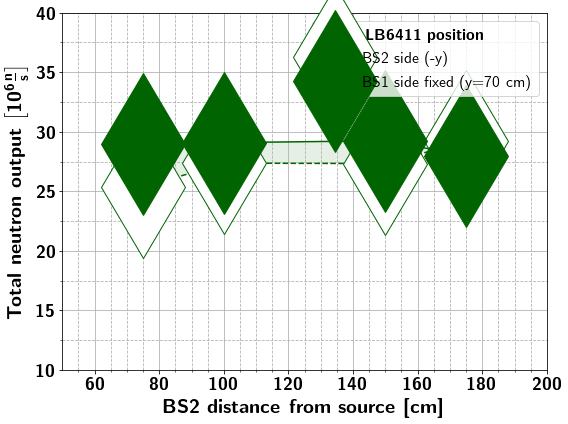

In [16]:
fs = 20
y_scale = 1e6
xlims = [50, 200]
figname = 'BS_mapping_new_target_output_BS2_vs_BS1_EAST'
if not os.path.exists(outputfolder+'/'+figname):
    os.makedirs(outputfolder+'/'+figname)
# plot neutron output
df_north = df[ df['direction'] == 'North']
df_south = df[ df['direction'] == 'South']
df_east = df[ df['direction'] == 'East']
df_south = df_south.sort_values(['distance'], ascending=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(1, 1, 1)
# x
minor_locator = AutoMinorLocator(4)
ax1.xaxis.set_minor_locator(minor_locator)
# y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)
# ax1.plot(df_north['distance'], df_north['output_from_BS']/y_scale, '--', label=r"BS2 forward (+x)", marker="o", markersize=markersize, color='darkblue', markerfacecolor='white')
# ax1.plot(df_south['distance'], df_south['output_from_BS']/y_scale, '--', label=r"BS2 backward (-x)", marker="s", markersize=markersize, color='darkred', markerfacecolor='white')
ax1.plot(df_east['distance'], df_east['output_from_BS']/y_scale, '--', label=r"BS2 side (-y)", marker='d', markersize=markersize, color='darkgreen', markerfacecolor='white')

# ax1.plot(df_north['distance'], df_north['output']/y_scale,  label=r"BS1 side fixed (y=70 cm)", marker="o", markersize=markersize, color='darkblue')
# ax1.plot(df_south['distance'], df_south['output']/y_scale, label=r"BS1 side fixed (y=70 cm)", marker="s", markersize=markersize, color='darkred')
ax1.plot(df_east['distance'], df_east['output']/y_scale, label=r"BS1 side fixed (y=70 cm)", marker='d', markersize=markersize, color='darkgreen')
# fig.subplots_adjust(left=0.14)
plt.xlabel(r'\textbf{BS2 distance from source [cm]}', fontsize=fs)
plt.ylabel(r'\textbf{Total neutron output} $\left[10^6 \frac{n}{s} \right]$', fontsize=fs)



ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')
# ax1.yaxis.set_major_locator(ticker.MultipleLocator(0.1e7))
# ax1.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1e'))
plt.ylim(ylims)
plt.xlim(xlims)
# ticks
# y_ticks = np.arange(1.0e6, 10e6+1.0e6, 1.0e6)
# y = np.arange(1, 10+1, 1)
# plt.yticks(y_ticks, y)
ax1.tick_params('x', colors='black', labelsize=fs-2)	
ax1.tick_params('y', colors='black', labelsize=fs-2)	
# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# for tick in ax1.yaxis.get_major_ticks():
#     tick.label.set_fontsize(14)
# plt.gca().fill_between(df_north['distance'],
#                        df_north['output_from_BS']/y_scale, df_north['output']/y_scale,
#                        facecolor='darkblue',
#                        alpha=0.1)
# plt.gca().fill_between(df_south['distance'],
#                        df_south['output_from_BS']/y_scale, df_south['output']/y_scale,
#                        facecolor='darkred',
#                        alpha=0.1)
plt.gca().fill_between(df_east['distance'],
                       df_east['output_from_BS']/y_scale, df_east['output']/y_scale,
                       facecolor='darkgreen',
                       alpha=0.1)
leg2 = plt.legend(fontsize=fs-4)
leg2.set_title(r"\textbf{LB6411 position}", prop = {'size': fs-4})
plt.tight_layout()
plt.savefig(f'{outputfolder}/{figname}/{figname}.pdf')
plt.show()
plt.close()

# Table with the relative differences

- values are in percent

In [17]:
# df.set_index('run', inplace=True)
df['relDiff'] = 100*np.abs(df['output_from_BS']-df['output'])/df['output']
df[['direction', 'distance', 'relDiff']]

,direction,distance,relDiff
0,East,75,12.448982
1,East,100,5.908883
2,East,150,6.563336
3,East,175,4.317244
4,South,75,14.381388
5,South,100,1.387146
6,South,150,6.306946
7,South,195,9.623054
8,North,70,9.973987
9,North,100,12.740659


## Turning the sphere 90 degree

Turning the LB6411 by 90 degrees sideways has no significant effect on the countrate as measured by the BS2. This measurement was done at 70 cm North direction. In the table below the measurements by BS2 are normalized with the mean of the white sphere counts (BS_norm_WS) and the mean of the sum of the "flatfield-corrected" reference detector counts (BS_norm_refDet).


| run | BS_norm_WS | BS_norm_refDet |
|---|---|---|
| straight | 22.3 | 13.8 |
| 90 degree turned | 22.2  | 13.6 |


## Bonner sphere mapping 2017-12-21 word document
 
- Setup
 
    - North (forward): In deuterium ion beam direction
    - South (backwards): Opposite to deuterium ion beam direction
    - West (side): Left of positive deuterium ion beam direction (towards the office)
    - East (side): Opposite to west (away from the office)
 
    - BS1 is the bonner sphere that we have always had connected to the PSYS. BS2 is the second bonner sphere by O. Morath. BS2 is moved around the room while BS1 is fixed at 70 cm West on the new standoff.
    - BS1 dose is read with arduino and raspberry pi roughly every 1 second. The dose has a small off-set with respect to the dose on the display of the PSYS-system. This is corrected for with a lookup table which contains values taken by hand between reading of the pi and reading of the display. The dose signal is averaged over 30 seconds interval.
    - BS2 countrate is integrated with an arduino due over a 30 second interval. 
    - White sphere countrate is integrated with the same arduino due over 30 second interval. The white sphere is on the ground below the generator.
    - Four of Benoits reference detectors are placed atop the table of the aluminium frame. The countrate of each detector is integrated over a 30 second interval.
 
- Mapping and calculations
 
    - BS2 is moved in east, north and south direction, recording all signals over 5-6 minutes, which corresponds to an uncertainty in the white sphere countrate of below 1%. The white sphere countrate is the lowest countrate of all signals.
    - Neutron generator: HV is -90 kV, current is 1 mA, target is rotating with ca 220-250 rpm, pressure in the ion source is in the order of 4-5 e-2 mbar. Higher HV operation was not possible due to sparks outside of the chamber from the RF cage to theferrofluidic feedthrough.
 
    - The saved signals are evaluated in the following way: 
        1. Finding the start time and end time of the measurement interval by finding the time when the BS2 signal was constant.
        2.	Summing reference detector signals in the measurement interval. There is a "flatfield" correction because the countrate is nonzero when the NG is not running. Note that there is no lead around the NG, so the x-rays could still produce a bias in the signal if not eliminated with the threshold.
        3.	Taking the mean of the signals in the interval (mean of BS2, White sphere, 4 reference detectors, dose).
        4.	Computing the output from the dose measurement (BS1) using an MCNP6 model. This is done relating the dose from BS1 to a countrate and then using the sum of tally response (bin center energy) with known LB6411 response.
            - Directional source with deuterium energy of 80 keV
            - Tally energy binning  0.0, 3.00, 0.05 MeV
            - Nps 2e8 
            - CUT:n j 1e-8
        5. Computing the output from the BS2 countrate by dividing the averaged countrate in the measurement interval by 30seconds, which yields (average) counts per second in the BS2. Then taking the same MCNP6 model allows to determine the neutron output from that 

- Effect of the orientation of the LB6411
 
    - Turning the LB6411 by 90 degrees sideways has no significant effect on the countrate as measured by the BS2. This measurement was done at 70 cm North direction. In the table below the measurements by BS2 are normalized with the mean of the white sphere counts (BS_norm_WS) and the mean of the sum of the "flatfield-corrected" reference detector counts (BS_norm_refDet).

- note that for all bonner sphere measurements the measurement time was adjusted so that the total number of counts in the BS2 had a statistical uncertainty below 1%. See the excel file for that /Users/hkromer/02_PhD/02_Data/06.BS_Mapping/BS_mapping/2017-10-12_BS_Mapping/2017-10-12_BS_Mapping.xlsx
